In [38]:
import json
import nltk
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean
from scipy.stats import norm
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models.word2vec import Word2Vec
import multiprocessing
from sklearn import utils
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, concatenate, Activation
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model
#nltk.download('stopwords')

In [2]:
#Read Train Dataset
tweets=pd.read_csv("D:/Thesis/Code/Data/train_data.csv")

In [ ]:
tweets.head()

In [3]:
#Data Cleaning
tok = WordPunctTokenizer()
#stop_words = set(stopwords.words('english')) 
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
pat3 = r'RT @[A-Za-z0-9_]+'
pat4 = r'RT @[A-Za-z0-9_ ] RT+'
#combined_pat = r'|'.join((pat1, pat2,pat3))
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
rt_pattern= re.compile(pat3,flags=re.IGNORECASE)
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    if rt_pattern.match(bom_removed):
        rt_stripped=re.sub(pat3,'',bom_removed)
        stripped = re.sub(combined_pat, '', rt_stripped)
    else:
        stripped = re.sub(combined_pat, '', bom_removed)
        stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    #tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [4]:
x = len(tweets.index)
nums = [0,x]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%525 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(tweets['text'][i]))
    clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])

Cleaning and parsing the tweets...

Tweets 525 of 5250 has been processed
Tweets 1050 of 5250 has been processed
Tweets 1575 of 5250 has been processed
Tweets 2100 of 5250 has been processed
Tweets 2625 of 5250 has been processed
Tweets 3150 of 5250 has been processed
Tweets 3675 of 5250 has been processed
Tweets 4200 of 5250 has been processed
Tweets 4725 of 5250 has been processed
Tweets 5250 of 5250 has been processed


In [5]:
clean_df['target'] = tweets.sentiment

In [ ]:
clean_df.head()

In [6]:
x = clean_df.text
y = clean_df.target
SEED = 5
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.3, random_state=SEED)

In [7]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [8]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [9]:
#Pure Distributed Bag of Words
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(validation_vecs_dbow, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1650187.05it/s]
W0818 07:31:11.659564 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2642200.14it/s]
W0818 07:31:11.829520 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1927866.92it/s]
W0818 07:31:11.999475 15064 base_any2vec.py:1386] under 10 

W0818 07:31:16.709492 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6696315120711563

In [10]:
#Pure Distributed Memory Mean
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(validation_vecs_dmm, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0818 07:31:32.743225 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2629265.19it/s]
W0818 07:31:33.036234 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 5257902.58it/s]
W0818 07:31:33.312040 15064 base_any2vec.py:1386] under 10 

W0818 07:31:41.106801 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6467598475222364

In [11]:
#DBOW+DMM
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_validation, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)
clf.score(validation_vecs_dbow_dmm, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6696315120711563

In [12]:
#Separate Word2Vec
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2,
                         workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1316046.86it/s]


In [13]:
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2,
                       workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                      total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

def get_w2v_mean(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec
  
def get_w2v_sum(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
        except KeyError:
            continue
    return vec
  
train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_train]))
validation_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_mean, y_train)
print(clf.score(validation_vecs_cbowsg_mean, y_validation))

train_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_train]))
validation_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_sum, y_train)
print(clf.score(validation_vecs_cbowsg_sum, y_validation))

100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1051279.29it/s]
W0818 07:31:53.733140 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2570939.40it/s]
W0818 07:31:53.778019 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2631779.13it/s]
W0818 07:31:53.822898 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2589076.54it/s]
W0818 07:31:53.871802 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a

W0818 07:31:55.286584 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2571840.22it/s]
W0818 07:31:55.342433 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2634928.32it/s]
W0818 07:31:55.393298 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 2632723.10it/s]
W0818 07:31:55.445159 15064 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|███████████████████████████████████████████████████████████████████

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6581956797966964


C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6632782719186785


In [14]:
#w2v general
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [15]:
#Word vectors extracted from Doc2Vec models with custom weighting
cvec = CountVectorizer(max_features=100000)
cvec.fit(x_train)

neg_train = x_train[y_train == 0]
pos_train = x_train[y_train == 1]
neu_train = x_train[y_train == 2]
neg_doc_matrix = cvec.transform(neg_train)
pos_doc_matrix = cvec.transform(pos_train)
neu_doc_matrix = cvec.transform(neu_train)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))
term_freq_df2 = pd.DataFrame([neg,pos,neu],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive','neutral']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive'] + term_freq_df2['neutral']
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
pos_hmean = term_freq_df2.pos_normcdf_hmean


#w2v_pos_hmean = {}
#for w in model_ug_dbow.wv.vocab.keys():
#    if w in pos_hmean.keys():
#        w2v_pos_hmean[w] = np.append(model_ug_dbow[w],model_ug_dmm[w]) * pos_hmean[w]
        
#train_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_train]))
#validation_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_validation]))
#clf = LogisticRegression()
#clf.fit(train_vecs_w2v_poshmean_mean, y_train)
#print(clf.score(validation_vecs_w2v_poshmean_mean, y_validation))

#train_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_train]))
#validation_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_validation]))
#clf = LogisticRegression()
#clf.fit(train_vecs_w2v_poshmean_sum, y_train)
#print(clf.score(validation_vecs_w2v_poshmean_sum, y_validation))

In [16]:
#Separately trained Word2Vec with custom weighting (Average/Sum)
w2v_pos_hmean_01 = {}
for w in model_ug_cbow.wv.vocab.keys():
    if w in pos_hmean.keys():
        w2v_pos_hmean_01[w] = np.append(model_ug_cbow[w],model_ug_sg[w]) * pos_hmean[w]
        
train_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_train]))
validation_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_mean_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_mean_01, y_validation))

train_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_train]))
validation_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_sum_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_sum_01, y_validation))

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6797966963151207


C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6810673443456162


In [ ]:
model_ug_cbow.save("w2v_model_ug_cbow.word2vec")

In [ ]:
model_ug_sg.save("w2v_model_ug_sg.word2vec")

In [17]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

FileNotFoundError: [Errno 2] No such file or directory: 'w2v_model_ug_cbow.word2vec'

In [18]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [20]:
length = []
for x in x_train:
    length.append(len(x.split()))
max(length)

30

In [21]:
x_train_seq = pad_sequences(sequences, maxlen=45)

In [22]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
x_train_seq[:5]

In [23]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=45)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(512, activation='relu'))
model_ptw2v.add(Dense(10, activation='softmax'))
model_ptw2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=64, verbose=2)

W0818 07:32:35.463746 15064 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 07:32:35.880815 15064 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 07:32:35.956517 15064 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 07:32:36.059191 15064 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0818 07:32:36.074155 15

Train on 3675 samples, validate on 787 samples
Epoch 1/5
 - 16s - loss: 0.9525 - acc: 0.6120 - val_loss: 0.8348 - val_acc: 0.6417
Epoch 2/5
 - 14s - loss: 0.5946 - acc: 0.7671 - val_loss: 0.7706 - val_acc: 0.6925
Epoch 3/5
 - 14s - loss: 0.1957 - acc: 0.9478 - val_loss: 0.8482 - val_acc: 0.6645
Epoch 4/5
 - 14s - loss: 0.0664 - acc: 0.9839 - val_loss: 0.9327 - val_acc: 0.6709
Epoch 5/5
 - 14s - loss: 0.0452 - acc: 0.9886 - val_loss: 1.0299 - val_acc: 0.6595


In [24]:
tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, input_length=45)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10)(merged)
output = Activation('softmax')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

W0818 07:33:50.700862 15064 deprecation.py:506] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 44, 100)      40100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 43, 100)      60100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [25]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=64, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 3675 samples, validate on 787 samples
Epoch 1/5
3675/3675 [==============================] - ETA: 1:18 - loss: 2.3267 - acc: 0.0000e+0 - ETA: 44s - loss: 2.2586 - acc: 0.3047    - ETA: 33s - loss: 2.1899 - acc: 0.40 - ETA: 28s - loss: 2.1183 - acc: 0.47 - ETA: 24s - loss: 2.0358 - acc: 0.51 - ETA: 22s - loss: 1.9503 - acc: 0.54 - ETA: 20s - loss: 1.8917 - acc: 0.54 - ETA: 18s - loss: 1.8141 - acc: 0.55 - ETA: 17s - loss: 1.7418 - acc: 0.56 - ETA: 17s - loss: 1.6656 - acc: 0.57 - ETA: 16s - loss: 1.5980 - acc: 0.58 - ETA: 15s - loss: 1.5625 - acc: 0.57 - ETA: 14s - loss: 1.5207 - acc: 0.58 - ETA: 14s - loss: 1.4788 - acc: 0.58 - ETA: 13s - loss: 1.4389 - acc: 0.59 - ETA: 13s - loss: 1.4202 - acc: 0.58 - ETA: 12s - loss: 1.4068 - acc: 0.58 - ETA: 12s - loss: 1.3838 - acc: 0.57 - ETA: 11s - loss: 1.3543 - acc: 0.57 - ETA: 11s - loss: 1.3347 - acc: 0.56 - ETA: 11s - loss: 1.3191 - acc: 0.56 - ETA: 10s - loss: 1.2952 - acc: 0.56 - ETA: 10s - loss: 1.2794 - acc: 0.57 - ETA: 9s - los

3675/3675 [==============================] - ETA: 14s - loss: 0.2098 - acc: 0.95 - ETA: 13s - loss: 0.1976 - acc: 0.95 - ETA: 13s - loss: 0.1830 - acc: 0.96 - ETA: 14s - loss: 0.1937 - acc: 0.96 - ETA: 13s - loss: 0.1983 - acc: 0.95 - ETA: 13s - loss: 0.2089 - acc: 0.94 - ETA: 13s - loss: 0.2062 - acc: 0.93 - ETA: 13s - loss: 0.2103 - acc: 0.93 - ETA: 12s - loss: 0.2074 - acc: 0.93 - ETA: 12s - loss: 0.2078 - acc: 0.93 - ETA: 12s - loss: 0.2156 - acc: 0.93 - ETA: 11s - loss: 0.2099 - acc: 0.93 - ETA: 11s - loss: 0.2076 - acc: 0.93 - ETA: 11s - loss: 0.2078 - acc: 0.93 - ETA: 11s - loss: 0.2141 - acc: 0.93 - ETA: 10s - loss: 0.2175 - acc: 0.93 - ETA: 10s - loss: 0.2172 - acc: 0.93 - ETA: 10s - loss: 0.2171 - acc: 0.93 - ETA: 9s - loss: 0.2212 - acc: 0.9326 - ETA: 9s - loss: 0.2198 - acc: 0.933 - ETA: 9s - loss: 0.2181 - acc: 0.934 - ETA: 9s - loss: 0.2147 - acc: 0.936 - ETA: 8s - loss: 0.2107 - acc: 0.938 - ETA: 8s - loss: 0.2108 - acc: 0.938 - ETA: 8s - loss: 0.2094 - acc: 0.938 - ETA:

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)
lr_with_tfidf.score(x_test_tfidf,y_test)
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [31]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.70.hdf5')

In [28]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [32]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

788/788 [==============================] - ETA:  - ETA:  - ETA:  - 0s 300us/step


[0.7598611273741359, 0.6916243651796719]

In [33]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

In [43]:
from sklearn.metrics import roc_curve, auc
n_classes=3
y = label_binarize(y_test, classes=[0,1,2])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], yhat_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

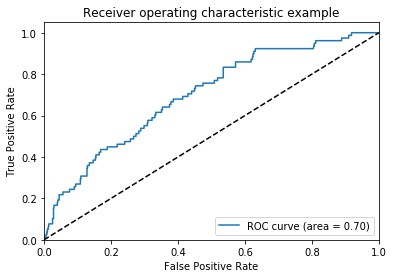

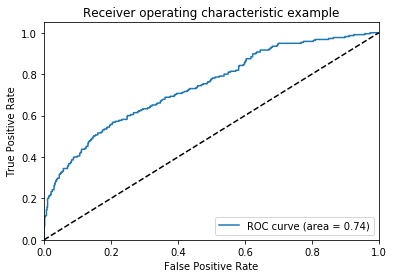

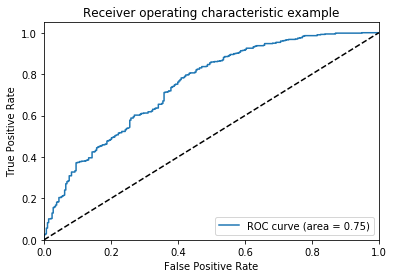

In [47]:
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Test DataSet Work

In [ ]:
#For Reading Test Dataset
def read_data(tweets_data_path):
    tweets_data = []
    tweets_file = open(tweets_data_path, "r")
    line = tweets_file.readline()
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except:
            continue
    data = pd.DataFrame.from_dict(tweets_data)
    return data

In [ ]:
#Read Test Dataset
tweet_data=read_data("D:/Thesis/autonomousDriveMulti.json")
tweet_data1=read_data("D:/Thesis/autonomousDrive.json")
tweet_data2=read_data("D:/Thesis/python.json")
tweets= pd.concat([tweet_data, tweet_data1,tweet_data2], ignore_index=True)

In [ ]:
#For Test Dataset Only
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar')

In [ ]:
#For Test Dataset Only
tweets_by_lang = tweets['source'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Source', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar')

In [ ]:
#tweets_data_path = 'D:/Thesis/autonomousDrive.json'

#tweets_data = []
#tweets_file = open(tweets_data_path, "r")
#line = tweets_file.readline()
#for line in tweets_file:
#    try:
#        tweet = json.loads(line)
#        tweets_data.append(tweet)
#    except:
#        continue

In [ ]:
#tweets = pd.DataFrame.from_dict(tweets_data)
#tweets = pd.read_excel("D:\\Thesis\\Code\\tweet.xlsx")

In [ ]:
#Conversion to xlsx (optional)
writer = ExcelWriter('tweet.xlsx')
tweets.to_excel(writer,'Sheet1')
writer.save()

In [ ]:
#For Test Dataset Only
tweets['created_at'] = pd.to_datetime(tweets.created_at)
tweets['source'] = tweets['source'].str.extract('>(.+?)<', expand=False).str.strip()
tweets['pre_clean_len'] = [len(t) for t in tweets.text]

In [ ]:
#For Test Dataset Only
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(tweets.pre_clean_len)
plt.show()

In [ ]:
#Test Data Clean
x = len(tweets.index)
nums = [0,x]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%881 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(tweets['text'][i]))
    clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])

In [ ]:
text = " ".join(message for message in tweets.text)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2400, height = 1600).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='gaussian')
plt.axis("off")
plt.show()

In [ ]:
time_len=pd.Series(data=tweets['pre_clean_len'].values, index=tweets['created_at'])
time_len.plot(figsize=(16, 4), color='r')
plt.show()

In [ ]:
#clean_df.groupby(level=0).first()

# END